**Start with your name(s) and student number(s)**

Team:

Daniel Knuijt | 15662942

Diederick van der Slot | 15462625

Carmen van der Lans | 15834468


# Outline


In this notebook we will look at extracting different assignments from the PGMs in an efficient way. We do this in two parts:

For the first part we want to extract the assignment that gives the highest probability (a.k.a. the mode) given certain conditionals and evidence. We do this through a Max-Product version of Variable Elimination (VE).

For the second part we will extract assignments randomly, where the probability of extraction is based on the probability of the assignment in the model. This is just a complicated way to say that we will do sampling. We will learn how to sample efficiently from a PGM through the Gibbs sampling algorithm, a simple sampling algorithm that makes use of the graphical structure to avoid constructing large factors.

We will use an example of reasoning w.r.t. a medical diagnosis to build up the intuition and the methods. We will apply the methods to a toy language generation example.

This is a high-level outline of the notebook, you will find exercises in most sections.

1. We start with constructing the BN (DAG + CPD) (similar to last week)
2. We will implement and reason about naive (arg)max inference for probability queries
3. Next, we will implement and reason about the Max-Product VE algorithm 
4. We will implement gibbs sampling and compare it to the exact case
5. We will check whether convergence/mixing actually happens
6. We will look at calculating expectations using samples

**Table of Exercises**

The exercises and the points they are worth are shown below. 


1. Max-Product Inference - Exhaustive [1]
2. Max-Product Inference - Exhaustive - Conditional Query [1]
3. Max-Product VE [1]
4. Exact but Intractable Sampling (parts 1 and 2) [2]
5. Gibbs sampling (parts 1 and 2) [2]
6. Studying Convergence [2]
7. Expectations [1]


**Use of AI tools**

In this course we expect _you_ and your team members to author your work.
AI tools are not to be used for drafts, nor code completion, nor revisions, nor as a source of feedback. If you do use AI, it should not contribute to the substance of what you present as your work.  

At the end of this notebook you will find a section on _Use of AI tools_. **Make sure to read and complete it**. 
By submitting a version of this notebook for assessment, you agree with our terms.

# Setting Up

Take care of dependencies:

In [38]:
!pip install tabulate
!pip install --upgrade --force-reinstall  git+https://github.com/probabll/pgmini.git

  Cloning https://github.com/probabll/pgmini.git to /private/var/folders/m8/s9zb9bln1_z25d4dfn27nnkc0000gn/T/pip-req-build-a8mwqjw9
  Running command git clone --filter=blob:none --quiet https://github.com/probabll/pgmini.git /private/var/folders/m8/s9zb9bln1_z25d4dfn27nnkc0000gn/T/pip-req-build-a8mwqjw9
  Resolved https://github.com/probabll/pgmini.git to commit d7abb0bd06452ba9f24b9f11634b944448efa69c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.

In [39]:

import pgmini
assert pgmini.__version__ == '0.4.0', "Don't forget to update pgmini and restart your kernel\n!pip install --upgrade --force-reinstall  git+https://github.com/probabll/pgmini.git"


In [40]:
from pgmini.m1 import OutcomeSpace, DAG
from pgmini.m2 import TabularFactor, UGraph
from pgmini.m3 import TabularCPDFactor, PGM, BayesianNetwork, MarkovNetwork 
from pgmini.m4 import split_factors, sum_product_variable_elimination, max_product_variable_elimination, rhat_split
from pgmini.util import display_full_table, pgm_to_tabular_factor, pgm_to_df
from pgmini.util import make_samples_df, df_to_factor, tvd
from joblib import Parallel, delayed
import functools
import itertools
from collections import defaultdict
import numpy as np
from tabulate import tabulate
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import urllib.request
from collections import Counter


**Misconception example**. This is a little helper that will be useful when demonstrating some of the functionalities in the notebook. It returns the Misconception example as we covered in class. 

The actual exercises will not be based on the Misconception example, instead they will be based on the Medical BN example, which we will construct afterwards.

In [41]:
def make_misconception_example():
    """The Misconception MN from class"""
    
    misconception_outcome_spaces = {
        'A': OutcomeSpace(['a0', 'a1']), 
        'B': OutcomeSpace(['b0', 'b1']),
        'C': OutcomeSpace(['c0', 'c1']),
        'D': OutcomeSpace(['d0', 'd1'])
    }
    
    # Define factors
    phi1 = TabularFactor(
        ['A', 'B'],
        misconception_outcome_spaces,
        [[30, 5], [1, 10]]
    )
    phi2 = TabularFactor(
        ['B', 'C'],
        misconception_outcome_spaces,
        [[100, 1], [1, 100]]
    )
    phi3 = TabularFactor(
        ['C', 'D'],
        misconception_outcome_spaces,
        [[1, 100], [100, 1]]
    )
    phi4 = TabularFactor(
        ['D', 'A'],
        misconception_outcome_spaces,
        [[100, 1], [1, 100]]
    )
        
    return MarkovNetwork([phi1, phi2, phi3, phi4])    

You can view the misconception MN structure

In [42]:
misconception_mn = make_misconception_example()
print(misconception_mn.graph)

+-------------------+
| nodes and edges   |
+===================+
| A                 |
+-------------------+
| B                 |
+-------------------+
| C                 |
+-------------------+
| D                 |
+-------------------+
| A -- B            |
+-------------------+
| A -- D            |
+-------------------+
| B -- C            |
+-------------------+
| C -- D            |
+-------------------+


And, for small PGMs, you can afford to build a table view of the joint distribution. The helper function below, from pgmini, builds a TabularFactor out of the product of all factors in the PGM. 

In [43]:
pgm_to_tabular_factor(misconception_mn)

A    B    C    D         Value
---  ---  ---  ---  ----------
a0   b0   c0   d0   300000
a0   b0   c0   d1   300000
a0   b0   c1   d0   300000
a0   b0   c1   d1       30
a0   b1   c0   d0      500
a0   b1   c0   d1      500
a0   b1   c1   d0        5e+06
a0   b1   c1   d1      500
a1   b0   c0   d0      100
a1   b0   c0   d1        1e+06
a1   b0   c1   d0      100
a1   b0   c1   d1      100
a1   b1   c0   d0       10
a1   b1   c0   d1   100000
a1   b1   c1   d0   100000
a1   b1   c1   d1   100000

# Medical BN #

This is the PGM that will be used for the exercises. It should be familiar to you, since we used it last week.

When going to the doctor, we dont expect the doctor to say; you have a fever and bronchitis with this probability, a fever and no bronchitis with this probability, no fever but bronchitis with this probability and no fever nor bronchitis with this probability.

A normal doctor would just say; it is likely that you have/don't have fever and that you have/don't have bronchites. In the first part of the notebook we will look at how to efficiently find this mode/most likely outcome.

Similar to last week, we define the medical BN example:

In [44]:
def make_medical_example():
    medical_outcome_spaces = {
        'I': OutcomeSpace(['i0', 'i1']),
        'S': OutcomeSpace(['s0', 's1']),
        'ST': OutcomeSpace(['st0', 'st1']),
        'F': OutcomeSpace(['f0', 'f1']),
        'B': OutcomeSpace(['b0', 'b1']),
        'C': OutcomeSpace(['c0', 'c1']),
        'W': OutcomeSpace(['w0', 'w1'])
    }
    
    # Factors
    phi_I = TabularCPDFactor([], 'I', medical_outcome_spaces, [0.9, 0.1])
    phi_S = TabularCPDFactor([], 'S', medical_outcome_spaces, [0.7, 0.3])
    phi_ST = TabularCPDFactor(['I'], 'ST', medical_outcome_spaces, [[0.99, 0.01], [0.8, 0.2]])
    phi_F = TabularCPDFactor(['I'], 'F', medical_outcome_spaces, [[0.9, 0.1], [0.05, 0.95]])
    phi_B = TabularCPDFactor(['I', 'S'], 'B', medical_outcome_spaces, 
    [[[0.999, 0.001], [0.25, 0.75]], [[0.05, 0.95], [0.1, 0.9]]])
    phi_C = TabularCPDFactor(['B'], 'C', medical_outcome_spaces, [[0.95, 0.05], [0.25, 0.75]])
    phi_W = TabularCPDFactor(['B'], 'W', medical_outcome_spaces, [[0.999, 0.001], [0.5, 0.5]])
    
    return BayesianNetwork([phi_I, phi_S, phi_ST, phi_F, phi_B, phi_C, phi_W])

You can view the BN structure

In [45]:
medical_bn = make_medical_example()
print(medical_bn.dag)

+-----------+---------+
| parents   | child   |
+===========+=========+
|           | I       |
+-----------+---------+
|           | S       |
+-----------+---------+
| I         | F       |
+-----------+---------+
| I         | ST      |
+-----------+---------+
| I, S      | B       |
+-----------+---------+
| B         | C       |
+-----------+---------+
| B         | W       |
+-----------+---------+


And, because it's a small PGM, we can construct and display the tabular view of the joint distribution. But mind that this is just to help us understand what we are doing (in practice, you can almost never do this, and that's why we create algorithms to make it unnecessary to ever build this thing).

In [46]:
medical_bn_table = pgm_to_tabular_factor(medical_bn) # this can only be done for toy examples, as a table view of the joint distribution is typically intractable
print(medical_bn_table) 

I    S    ST    F    B    C    W          Value
---  ---  ----  ---  ---  ---  ---  -----------
i0   s0   st0   f0   b0   c0   w0   0.532198
i0   s0   st0   f0   b0   c0   w1   0.00053273
i0   s0   st0   f0   b0   c1   w0   0.0280104
i0   s0   st0   f0   b0   c1   w1   2.80384e-05
i0   s0   st0   f0   b1   c0   w0   7.01662e-05
i0   s0   st0   f0   b1   c0   w1   7.01662e-05
i0   s0   st0   f0   b1   c1   w0   0.000210499
i0   s0   st0   f0   b1   c1   w1   0.000210499
i0   s0   st0   f1   b0   c0   w0   0.0591331
i0   s0   st0   f1   b0   c0   w1   5.91922e-05
i0   s0   st0   f1   b0   c1   w0   0.00311227
i0   s0   st0   f1   b0   c1   w1   3.11538e-06
i0   s0   st0   f1   b1   c0   w0   7.79625e-06
i0   s0   st0   f1   b1   c0   w1   7.79625e-06
i0   s0   st0   f1   b1   c1   w0   2.33888e-05
i0   s0   st0   f1   b1   c1   w1   2.33888e-05
i0   s0   st1   f0   b0   c0   w0   0.00537573
i0   s0   st1   f0   b0   c0   w1   5.38111e-06
i0   s0   st1   f0   b0   c1   w0   0.000282933
i0

# Max-Product (or MAP) Inference

The so-called "MAP inference" task (MAP stands for maximum a posteriori) is the task of finding the **mode** of the distribution. The _mode_ is the joint assignment that the model assigns highest probability to. 

That is, for a distribution $P_\Phi(\boldsymbol{X})$ the mode is the outcome $\boldsymbol{x}^\star$ below:

$\boldsymbol{x}^\star = \arg\!\max_{\boldsymbol{x} \in \text{Val}(\boldsymbol{X})}~P_\Phi(\boldsymbol{X}=\boldsymbol{x})= \arg\!\max_{\boldsymbol{x} \in \text{Val}(\boldsymbol{X})}~\tilde P_\Phi(\boldsymbol{X}=\boldsymbol{x})$

The MAP inference task is more generally known as `maximum-product` inference since we are computing the maximum of a large _product of factors_.

It is worthwhile to realise that max-product inference does not require a normalised distribution, since the argmax (mode) is the same whether or not the factor product is normalised.

## Naive Max-Product Inference

A naive implementation of max-product inference is essentially an exhaustive search: 1) enumerate joint outcomes, 2) assess their (unnormalised) probability under the model (e.g., using `PGM.evaluate`), 3) find the outcome whose (unnormalised) probability is maximum.

**EXERCISE - Max-Product Inference - Exhaustive** Find and report the mode of the `medical_bn` via an exhaustive procedure.

To know if your solution is correct, you can compare your result to what `TabularFactor.argmax()` produces.

In [47]:
def exhaustive_max_product_inference(pgm: PGM):  # other implementations are possible
    """Return the argmax assignment (dict) under the PGM"""
    
    variables = list(pgm.outcome_spaces.keys())
    domains = [pgm.outcome_spaces[v].outcomes for v in variables]

    best_assignment = None
    best_score = -math.inf

    for values in itertools.product(*domains):
        assignment = dict(zip(variables, values))

        score = pgm.evaluate(assignment)

        if score > best_score:
            best_score = score
            best_assignment = assignment

    return best_assignment

Example of how to test it (using the Misconception example):

In [48]:
print("Exhaustive search for Misconception example")
print("- argmax", exhaustive_max_product_inference(misconception_mn))
print("- argmax", pgm_to_tabular_factor(misconception_mn).argmax())

Exhaustive search for Misconception example
- argmax {'A': 'a0', 'B': 'b1', 'C': 'c1', 'D': 'd0'}
- argmax {'A': 'a0', 'B': 'b1', 'C': 'c1', 'D': 'd0'}


## Max-Product for Conditional Queries ##

Suppose we have some evidence $\boldsymbol{E}=\boldsymbol{e}$ and we want to find the maximum over some (but not necessarily) all of the variables that remain. 

We can do that by first expressing the appropriate conditional query using the VE algorithm as we did last week. We have provided an implementation for you. To distinguish VE when used for `sum-product` (marginal inference) as opposed to `max-product` (MAP inference), we have called it `sum_product_variable_elimination` in pgmini.

Remark: because the rest of this notebook will concern efficient inference, the function `sum_product_variable_elimination` does not return the product of the factors that remain in VE, instead it returns a Markov Network that uses those factors to represent the final query. This is the standard way to interact with VE in most professional PGM libraries. 

After the appropriate query has been expressed as a Markov network (which is the return of `sum_product_variable_elimination`) we can use it for max-product inference. 


Here we demo the `sum_product_variable_elimination` function for you

In [49]:
# We define the min degree heuristic to efficiently run VE
def min_degree(node, pgm: PGM):
    """Return number of factors whose scope contains the rv"""
    return (sum(1 if node in factor else 0 for factor in pgm.iterfactors()), str(node))

In [50]:
misconception_mn = make_misconception_example()
misconception_mn_BD_given_c1 = sum_product_variable_elimination(
    misconception_mn,
    {'B', 'D'},
    {'C': 'c1'},
    key=functools.partial(min_degree, pgm=misconception_mn),
)
print("P(B, D|C=c1) MN:")
print(misconception_mn_BD_given_c1.graph)
print("Convert MN to table")
print(pgm_to_tabular_factor(misconception_mn_BD_given_c1))
print("Exhaustive argmax")
print(exhaustive_max_product_inference(misconception_mn_BD_given_c1))

P(B, D|C=c1) MN:
+-------------------+
| nodes and edges   |
+===================+
| B                 |
+-------------------+
| D                 |
+-------------------+
| B -- D            |
+-------------------+
Convert MN to table
B    D           Value
---  ---  ------------
b0   d0   300100
b0   d1      130
b1   d0        5.1e+06
b1   d1   100500
Exhaustive argmax
{'B': 'b1', 'D': 'd0'}


**EXERCISE - Max-Product Inference - Exhaustive - Conditional Query**. For the `medical_bn`, what is the most likely outcome of fever and bronchitis and coughing given that we know someone has influenza. For this exercise you should use `sum_product_variable_elimination` to obtain an MN over the correct distribution, and then you can use an exhaustive search approach to reporting the argmax.

For VE, you can use the `min_degree` order heuristic implemented above.

In [51]:
medical_mn_FBC_given_I1 = sum_product_variable_elimination(
    medical_bn,
    {'F', 'B', 'C'},
    {'I': 'i1'},
    key=functools.partial(min_degree, pgm=medical_bn),
)

print("P(F, B, C | I=i1) as MN:")
print(medical_mn_FBC_given_I1.graph)

print("\nAs table:")
print(pgm_to_tabular_factor(medical_mn_FBC_given_I1))

# 2) Max-product (exhaustive) op deze MN
print("\nExhaustive MAP for (F, B, C | I=i1):")
print(exhaustive_max_product_inference(medical_mn_FBC_given_I1))

P(F, B, C | I=i1) as MN:
+-------------------+
| nodes and edges   |
+===================+
| B                 |
+-------------------+
| C                 |
+-------------------+
| F                 |
+-------------------+
| B -- C            |
+-------------------+

As table:
F    B    C         Value
---  ---  ---  ----------
f0   b0   c0   0.00030875
f0   b0   c1   1.625e-05
f0   b1   c0   0.00116875
f0   b1   c1   0.00350625
f1   b0   c0   0.00586625
f1   b0   c1   0.00030875
f1   b1   c0   0.0222063
f1   b1   c1   0.0666188

Exhaustive MAP for (F, B, C | I=i1):
{'F': 'f1', 'B': 'b1', 'C': 'c1'}


# Max-Product VE (or VE for MAP Inference)

Max-product VE is a relatively simple modification of sum-product VE where instead of _marginalising_ a variable out of a factor, when we eliminate it, we _maximise_ it out of the factor. 

That is, if we have a node $X$ and $\phi_1(X, Y)$ and $\phi_2(X, Z)$ are the relevant factors (whose scopes contain $X$), then sum-product VE eliminates $X$ via $\tau(Y, Z) = \sum_{x \in \text{Val}(X)} \phi_1(X=x, Y)\phi_2(X=x, Z)$, while max-product VE eliminates $X$ via $\tau(Y, Z) = \max_{x \in \text{Val}(X)} \phi_1(X=x, Y)\phi_2(X=x, Z)$.

By keeping track of the intermediate factors, which max-product VE maximises over, we can construct the assignment of the rvs that correspond to $\arg\!\max_{X,Y,Z} \tilde P_\Phi(X, Y, Z)$.


We implemented the function `max_product_variable_elimination` for you in pgmini. Feel free to inspect the function on github if you want to better understand the differences compared to sum-product VE. The function returns 2 things: the mode and a Markov network with the mode (mostly you can ignore this, you only really need the mode). See the demo below

In [52]:
print("VE for the Misconception example")
trace = []
misconception_argmax, _ = max_product_variable_elimination(
    misconception_mn, 
    key=functools.partial(min_degree, pgm=misconception_mn), 
    trace=trace # if you provide a `trace` list, you can then see the scope of the intermediate factor at each elimination step
)
# Note this operation still requires the whole table
# You will implement an efficient method later
print("- argmax", misconception_argmax)
print("- unnormalised probability", misconception_mn.evaluate(misconception_argmax))

VE for the Misconception example
- argmax {'D': 'd0', 'C': 'c1', 'B': 'b1', 'A': 'a0'}
- unnormalised probability 5000000.0


**EXERCISE - Max-Product VE** 

For the `medical_bn`, report:

1. The mode of the joint distribution (without evidence) and its **normalised** probability. 
2. The mode of the conditional distribution $P(B, C|I=i^1)$ and its **normalised** probability.

Your implementation should **never** build the tabular view of these distributions, instead it should use VE for sum-product inference and for max-product inference and, of course, for obtaining normalisation constants if they are necessary.

Compare the complexity to the exhaustive case in terms of the size of the largest tabular factor built.

Tip: if you are not sure you have normalised correctly, experiment with a small network for which you know the normaliser (e.g., the Misconception MN).

In [53]:
trace = []
joint_mode, _ = max_product_variable_elimination(
    medical_bn,
    key=functools.partial(min_degree, pgm=medical_bn),
    trace=trace,
)

joint_prob = medical_bn.evaluate(joint_mode)   # = P(mode)

print("Joint mode P(I,S,ST,F,B,C,W):")
print("  argmax =", joint_mode)
print("  normalised probability =", joint_prob)   # normaliser = 1 voor een BN

medical_mn_BC_given_i1 = sum_product_variable_elimination(
    medical_bn,
    {'B', 'C'},             # query-variabelen
    {'I': 'i1'},            # evidence
    key=functools.partial(min_degree, pgm=medical_bn),
)

trace = []
bc_mode, _ = max_product_variable_elimination(
    medical_mn_BC_given_i1,
    key=functools.partial(min_degree, pgm=medical_mn_BC_given_i1),
    trace=trace,
)

bc_unnorm = medical_mn_BC_given_i1.evaluate(bc_mode)

B_vals = medical_bn.outcome_spaces['B'].outcomes
C_vals = medical_bn.outcome_spaces['C'].outcomes

Z_bc = 0.0
for b in B_vals:
    for c in C_vals:
        Z_bc += medical_mn_BC_given_i1.evaluate({'B': b, 'C': c})

bc_norm = bc_unnorm / Z_bc

print("\nMode of P(B, C | I = i1):")
print("  argmax =", bc_mode)
print("  unnormalised probability =", bc_unnorm)
print("  normalised probability   =", bc_norm)

Joint mode P(I,S,ST,F,B,C,W):
  argmax = {'I': 'i0', 'B': 'b0', 'S': 's0', 'W': 'w0', 'ST': 'st0', 'F': 'f0', 'C': 'c0'}
  normalised probability = 0.5321975062634999

Mode of P(B, C | I = i1):
  argmax = {'B': 'b1', 'C': 'c1'}
  unnormalised probability = 0.070125
  normalised probability   = 0.70125


# Sampling Exactly but Intractably

In the first part of this notebook we focused on getting the assignment with the most likely outcome (the mode). 

In the second part of this notebook we focus on getting assignments randomly, where the probability of getting an assignment is defined by the probability of that assignment _according to the joint distribution_ (i.e. sampling). 

The mode is just the assignment that has the highest probability of being sampled.


Sampling "exactly" means sampling from the correct distribution. For a general PGM, there is no tractable algorithm to sample exactly. There are some special cases (BNs without evidence, certain BNs and certain MNs even with evidence), but we are covering the most general case. 

For small PGMs, we can still demonstrate what it means to sample exactly by essentially creating the table view of the normalised joint distribution and then sampling from it via the icdf method.

This is what we demonstrate below.

In [54]:
def sample_exactly_but_intractably(pgm: PGM, size=None, rng=np.random.default_rng()):
    """
    This builds a large table view of the PGM and then draws samples using the exact icdf method.
    pgm: the PGM we are sampling from
    size: as in numpy
        - if size is None, we return one a sample (a dict)
        - if size is a number, we return a list of samples (each sample is a dict)
    rng: numpy random number generator
    """
    # build table (this is generally intractable)
    table_view = pgm_to_tabular_factor(pgm).normalize()
    # icdf sample
    return table_view.sample(size, rng=rng)

In [55]:
sample_exactly_but_intractably(misconception_mn)

{'A': 'a0', 'B': 'b1', 'C': 'c1', 'D': 'd0'}

And, as we are sampling from a full table view anyway, we can also have conditional queries.

In [56]:
sample_exactly_but_intractably(misconception_mn_BD_given_c1)

{'B': 'b1', 'D': 'd0'}

`pgmini.util` has some rather useful helper functions:
- `make_samples_df` makes an empirical distribution out of a list of samples
- `df_to_factor` can convert a data frame (such as obtained by `make_samples_df` to a TabulaFactor)
- `tvd` can compare distribution and/or empirical estimates of distributions in terms of Total Variation Distance

[Here](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures) you can check the explanation of [Total Variation Distance](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures)

We will be using these below.

Below we demo how you can use these helper functions to compare the joint distribution to an empirical distribution obtained by sampling in terms of TVD. Of course, this only works when we are able to sample exactly.

In [57]:
# draw samples exactly but intractably, 
# convert the samples to a DataFrame
# convert the entire PGM to a DataFrame and compare to the samples DataFrame via TVD
misconception_exact_samples_df = make_samples_df(sample_exactly_but_intractably(misconception_mn, size=100))
print("Misconception TVD(PGM->df, samples->df):", tvd(pgm_to_df(misconception_mn, normalize=True), misconception_exact_samples_df))

Misconception TVD(PGM->df, samples->df): 0.07891727669595545


**EXERCISE - Exact but Intractable Sampling**

For the medical BN, sample exactly and compare the empirical distribution to the target distribution in terms of TVD in the following cases:
1. No evidence
2. Evidence: $S=s^1$

For each case above, you should experiment with sample size (10, 100 and 1000 samples). For each experiment (1 and 2) and for each sample size (10, 100, 1000) you should repeat the experiment 20 times so that you can see how TVD varies. Plot the results conveniently (for example, using a boxplot). 

Finally, discuss what you observe in your experiments. 

In [58]:
def run_tvd_experiments(pgm, label, sizes=(10, 100, 1000), repeats=20, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    records = []

    for size in sizes:
        for rep in range(repeats):
            samples = sample_exactly_but_intractably(pgm, size=size, rng=rng)
            samples_df = make_samples_df(samples)

            target_df = pgm_to_df(pgm, normalize=True)

            tvd_val = tvd(target_df, samples_df)

            records.append({
                "case": label,
                "size": size,
                "rep": rep,
                "TVD": tvd_val,
            })

    return pd.DataFrame(records)

tvd_no_evidence_df = run_tvd_experiments(medical_bn, label="no_evidence")

all_vars = set(medical_bn.outcome_spaces.keys())
query_vars = all_vars - {"S"}

medical_mn_given_S1 = sum_product_variable_elimination(
    medical_bn,
    query_vars,
    {"S": "s1"},
    key=functools.partial(min_degree, pgm=medical_bn),
)

tvd_S1_df = run_tvd_experiments(medical_mn_given_S1, label="S=s1")

tvd_results_df = pd.concat([tvd_no_evidence_df, tvd_S1_df], ignore_index=True)
tvd_results_df.head()

,case,size,rep,TVD
0,no_evidence,10,0,0.298284
1,no_evidence,10,1,0.387507
2,no_evidence,10,2,0.590823
3,no_evidence,10,3,0.601441
4,no_evidence,10,4,0.345661


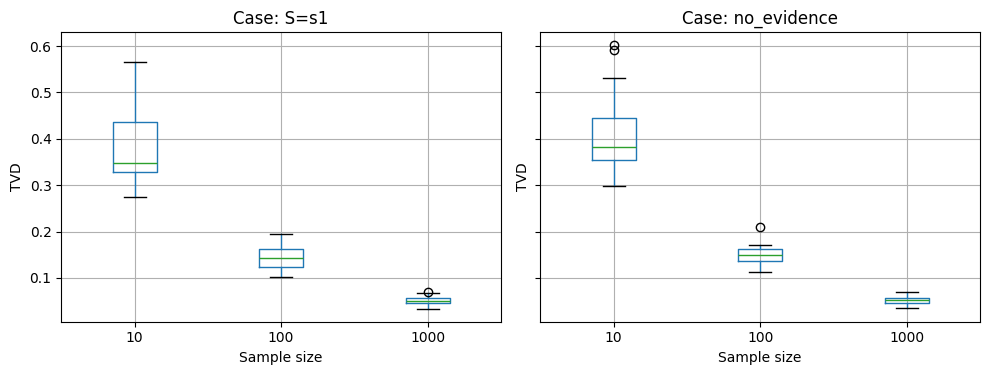

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (case, subdf) in zip(axes, tvd_results_df.groupby("case")):
    subdf.boxplot(column="TVD", by="size", ax=ax)
    ax.set_title(f"Case: {case}")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("TVD")

plt.suptitle("")
plt.tight_layout()
plt.show()

# Gibbs Sampling

As stated before, exact sampling is often computationally infeasible.

For a general PGM, we need to use a tractable Markov chain Monte Carlo (MCMC) sampler, such as a Gibbs sampler.

A Gibbs sampler simulates a chain of states, each state of the chain is a complete assignment of the rvs in the PGM.
To sample one state of this chain, we iterate over the rvs in the PGM in any order (fixed or random) resampling one rv at a time while keeping the others fixed. This means that each time we sample an rv we are certain to have fixed the rvs in its Markov blanket, and hence, resampling this one rv is a tractable operation. 

If we run the sampler for enough interations, under certain conditions discussed in class, the chain converges to something called the _stationary distribution_. The stationary distribution of a well designed sampler is going to be the joint distribution represented by our PGM. 

Of course, there are many hyperparameters in this procedure, and we typically have to run it for many iterations. But note that at no point this procedure will create an object that grows intractably large.

In [60]:
def gibbs_sampler(
    pgm: PGM,   
    initial_assignment: dict,
    num_iterations: int,
    burn_in: int = 0,
    thinning: int = 1,
    order=None,
    shuffle_order=True,
    rng=np.random.default_rng(),
):   
    """
    Simulate a Gibbs chain for a number of iterations and return a list of samples (each a dict).
    (possibly after discarding some samples, depending on burn-in and thinning).
    
    pgm: the model we are sampling from
        (if you need to condition on something, construct a PGM with reduced factors before calling this function)
    initial_assignment: a complete assignment of all of the pgm's rvs
    num_iterations: how many iterations we run the Gibbs sampler for
    burn_in: how many samples we discard from the beginning of the chain
    thinning: for some number k, collect every kth sample, discard the rest
    order: in which order should we resample rvs
    shuffle_order: whether to shuffle the order (uniformly at random) at the beginning of each iteration
    rng: a numpy random number generator
        (necessary so we can sample from factors; if not provided, we use np.random.default_rng())
    """    
    variables = set(pgm.iternodes())
    # validate
    assert variables <= set(initial_assignment.keys()), "initial_assignment must define every variable"
    
    if order is None: # fix an order if none is given
        order = list(pgm.iternodes())

    current_assignment = dict(initial_assignment)  
    
    samples = []
    for j in range(num_iterations):
        if shuffle_order:  # shuffle the order if needed
            permutation = rng.permutation(len(order))
        else:
            permutation = np.arange(len(order))
        for i in permutation:  # for each rv in order
            X = order[i]
            del current_assignment[X]  # remove rv from assignment
            # find relevant factors
            relevant, irrelevant = split_factors(X, pgm.iterfactors())
            # reduce the relevant factors (this is fixing the rvs in the rv's Markov Blanket)
            relevant = [f.reduce(current_assignment) for f in relevant]
            
            # compute product of factor for all relevant, reduced factors
            prod = functools.reduce(lambda a, b: a.product(b), relevant)
            # normalisation gives us the probability distribution over X given MB(X)
            P_X = prod.normalize()  
                        
            # then we can sample an new outcome
            # and that gives us a new assignment
            current_assignment[X] = P_X.sample(rng=rng)[X]
            
        # at the end of a complete pass through all rvs, we have a sample
        samples.append(dict(current_assignment))

    return samples[burn_in:][::thinning]

## Starting assignment

The idea of the Gibbs sampler is that we continuously sample one variable, conditioned on the assignment of the other variables as evidence. When starting from some initial assignment, running the gibbs sampling algorithm for long enough, the assignment we get will be as if we sampled from the distribution (under the assumptions discussed in class).


There are many ways we can start:
- for BNs, we can obtain a _forward sample_ (without evidence)
- for MNs, we can start from an arbitrary sample (simply starting from whatever outcome is possible of each and every rv, making this choice independently and arbitrarily at random)
- if we had access to data, we could start from an assignment that has been observed in the data
etc.

In [61]:
def draw_initial_assignment(pgm: PGM, rng=np.random.default_rng()):
    """
    Obtain an initial assignment of the PGM's RVs by any one of the procedures explained above.

    pgm: the PGM we are drawing the initial assignment from
    rng: a numpy random number generator

    The return type is a dictionary representing the assignment.
    """

    assignment = dict()
    for X, Val_X in pgm.iterrvs():
        id_x = rng.choice(len(Val_X))
        assignment[X] = Val_X.outcomes[id_x]
    return assignment


Now we demo how you can use Gibbs sampling (we demo it using Misconception). We also compare the result to the target distribution (since for this small PGM that can be done).

In [62]:
draw_initial_assignment(misconception_mn)

{'A': 'a0', 'B': 'b0', 'C': 'c1', 'D': 'd0'}

In [63]:
misconception_gibbs_samples_1 = gibbs_sampler(
    misconception_mn,
    draw_initial_assignment(misconception_mn),
    num_iterations=1000,
)
misconception_gibbs_samples_df = make_samples_df(misconception_gibbs_samples_1)

# Note that you can verify earlier answers using this table
print(misconception_gibbs_samples_df)
print("TVD Misconception(target, gibbs)", tvd(pgm_to_df(misconception_mn, normalize=True), misconception_gibbs_samples_df))

    B   A   D   C  Count  Value
0  b1  a0  d0  c1    817  0.817
1  b0  a1  d1  c0     54  0.054
2  b0  a0  d0  c1     52  0.052
3  b0  a0  d0  c0     31  0.031
4  b0  a0  d1  c0     22  0.022
5  b1  a1  d0  c1     16  0.016
6  b1  a1  d1  c1      5  0.005
7  b1  a1  d1  c0      3  0.003
TVD Misconception(target, gibbs) 0.13519161769769947


**EXERCISE - Gibbs Sampling**

For the medical BN, obtain samples via Gibbs sampling and compare the empirical distribution to the target distribution in terms of TVD in the following cases:

1. No evidence
2. Evidence: $S=s^1$. Remember that to perform Gibbs sampling conditionally, there is no need to use sum-product VE at all, rather you should simply reduce the factors before starting the chain and your initial state should be compatible with the evidence. 

For each case above, you should experiment with sample size (10, 100 and 1000 samples). For each experiment (1 and 2) and for each sample size (10, 100, 1000) you should repeat the experiment 20 times so that you can see how TVD varies. Plot the results conveniently (for example, using a boxplot). 

Finally, discuss what you observe in your experiments. 

In [64]:
medical_mn = MarkovNetwork(list(medical_bn.iterfactors()))

evidence = {'S': 's1'}
medical_mn_S1 = MarkovNetwork(
    [f.reduce(evidence) for f in medical_bn.iterfactors()]
)


def run_gibbs_experiment(pgm, label, sizes=(10, 100, 1000), repeats=20, rng=None):
    """
    pgm: PGM (hier een MarkovNetwork) waar we Gibbs op draaien
    label: string voor de case ("no_evidence" of "S=s1")
    sizes: sample sizes
    repeats: aantal herhalingen per sample size
    """
    if rng is None:
        rng = np.random.default_rng()

    records = []

    for size in sizes:
        for rep in range(repeats):
            init = draw_initial_assignment(pgm, rng=rng)

            burn_in = 100
            num_iterations = burn_in + size

            samples = gibbs_sampler(
                pgm=pgm,
                initial_assignment=init,
                num_iterations=num_iterations,
                burn_in=burn_in,
                thinning=1,
                shuffle_order=True,
                rng=rng,
            )

            samples_df = make_samples_df(samples)

            target_df = pgm_to_df(pgm, normalize=True)

            tvd_val = tvd(target_df, samples_df)

            records.append({
                "case": label,
                "size": size,
                "rep": rep,
                "TVD": tvd_val,
            })

    return pd.DataFrame(records)


# Case 1: geen evidence
tvd_no_ev = run_gibbs_experiment(medical_mn, "no_evidence")

# Case 2: evidence S = s1  (we gebruiken medical_mn_S1)
tvd_S1   = run_gibbs_experiment(medical_mn_S1, "S=s1")

tvd_gibbs_df = pd.concat([tvd_no_ev, tvd_S1], ignore_index=True)
tvd_gibbs_df.head()

,case,size,rep,TVD
0,no_evidence,10,0,0.403361
1,no_evidence,10,1,0.405349
2,no_evidence,10,2,0.467802
3,no_evidence,10,3,0.351591
4,no_evidence,10,4,0.439792


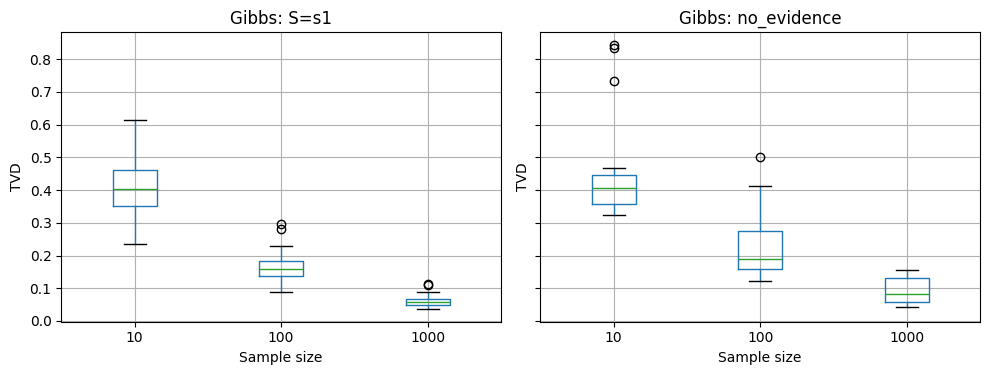

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (case, subdf) in zip(axes, tvd_gibbs_df.groupby("case")):
    subdf.boxplot(column="TVD", by="size", ax=ax)
    ax.set_title(f"Gibbs: {case}")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("TVD")

plt.suptitle("")
plt.tight_layout()
plt.show()

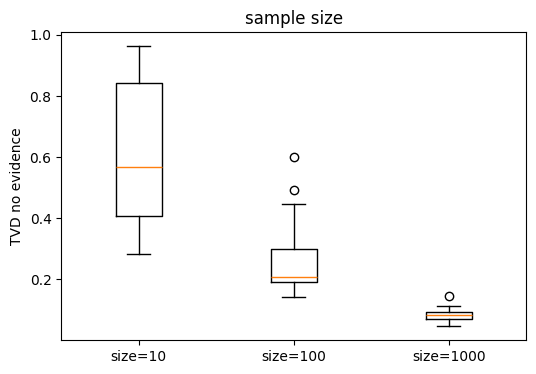

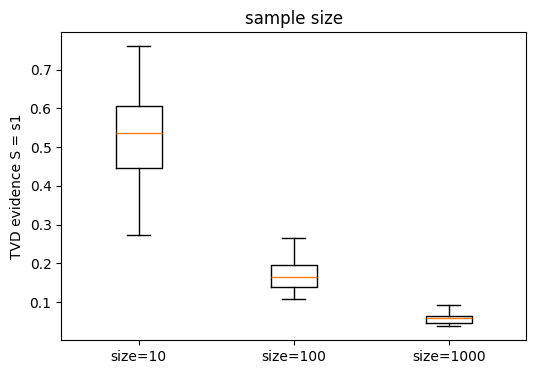

In [75]:
# mijn code voor Gibbs sampling (bivenste zelfde gelaten)

def experiment_gibbs(pgm, sample_size: int):
    res = []

    for i in range(20):
        initial = draw_initial_assignment(pgm)
        samples = gibbs_sampler(pgm, initial, num_iterations=sample_size)
        df_samples = make_samples_df(samples)
        df_joint = pgm_to_df(pgm, normalize=True)
        tvd_value = tvd(df_joint, df_samples)
        res.append(tvd_value)
    return res

def condition_bn(bn: BayesianNetwork, evidence: dict) -> MarkovNetwork:
    new_factors = []
    for f in bn.iterfactors():
        new_factors.append(f.reduce(evidence))
    return MarkovNetwork(new_factors)


# experiment 1: no evidence
gibbs_no_evidence_10    = experiment_gibbs(medical_bn, 10)
gibbs_no_evidence_100   = experiment_gibbs(medical_bn, 100)
gibbs_no_evidence_1000  = experiment_gibbs(medical_bn, 1000)

# experiment 1: evidence S = s1
S_evidence = {'S': 's1'}
medical_bn_cond = condition_bn(medical_bn, S_evidence)

gibbs_evidence_10    = experiment_gibbs(medical_bn_cond, 10)
gibbs_evidence_100   = experiment_gibbs(medical_bn_cond, 100)
gibbs_evidence_1000  = experiment_gibbs(medical_bn_cond, 1000)


# plot
plt.figure(figsize=(6,4))
data = [gibbs_no_evidence_10, gibbs_no_evidence_100, gibbs_no_evidence_1000]
labels = ['size=10', 'size=100', 'size=1000']

plt.boxplot(data, tick_labels=labels)
plt.ylabel('TVD no evidence')
plt.title('sample size')
plt.show()

plt.figure(figsize=(6,4))
data = [gibbs_evidence_10, gibbs_evidence_100, gibbs_evidence_1000]
labels = ['size=10', 'size=100', 'size=1000']

plt.boxplot(data, tick_labels=labels)
plt.ylabel('TVD evidence S = s1')
plt.title('sample size')
plt.show()



## Mixing / Convergence

When we start a Gibbs sampler from an initial assignment, the first few samples are typically not representative of the target distribution. The sampler needs time to "forget" its starting point and explore the state space according to the PGM's joint distribution. This process of transitioning from the initial state to sampling from the stationary distribution is called _mixing_ or _convergence_.

The number of initial samples that should be discarded (called the _burn-in_ period) depends on how quickly the chain converges. In practice, we often need to run the sampler for many iterations before the samples become representative of the target distribution.


### Approaches to Assess Convergence

There are two main approaches to assess convergence, each with different applicability:

1. **Comparing to the target distribution**: For small, tractable PGMs where we can compute the exact joint distribution, we can directly measure how close our Gibbs samples are to the target distribution using metrics like Total Variation Distance (TVD). As we run more iterations, the empirical distribution of our samples should get closer to the true distribution, and the TVD should decrease toward 0. This is the gold standard when available, but it's only feasible for toy examples.

In fact, you have (more or less) already done this in an earlier exercise when we were working with the medical BN!


2. **Multiple chain diagnostics**: For larger PGMs where computing the exact distribution is intractable, we use multiple chain diagnostics. The idea is to run several independent chains (each starting from a different initial assignment) and check if they are sampling from the same distribution. If chains have converged, they should all be exploring the same region of the state space, and statistics computed across chains should be similar. If chains haven't converged, they might be stuck in different modes or regions, leading to different statistics. By monitoring how R-hat changes over iterations and for different burn-in periods, we can assess whether the chains have mixed and determine an appropriate burn-in period.


***R-hat (Gelman-Rubin statistic)***

One of the most common diagnostics is the **R-hat** (or $\hat{R}$) statistic, also known as the Gelman-Rubin statistic. It compares the variance within chains to the variance between chains.

- **R-hat ≈ 1.00-1.05**: Good mixing (usually adequate for PGM use)
- **R-hat > 1.1**: Chains not yet mixing; probably stuck in different energy basins
- **R-hat >> 1.1**: Very poor mixing or chains starting from very different modes

We'll use the log unnormalized probability of each sample as the statistic to monitor. This is a scalar value that summarizes each sample and should converge across chains if mixing is good.

***Multiple Independent Chains***

To obtain multiple, independent chains, we typically simply initialise a number of Gibbs chains at different initial states. 

It's in fact possible to indeed simulate these chains in parallel. We wrote some helper code for you. 

In [66]:
def run_chain(sampler_fn, seed, init, args, kwargs):
    """Run one chain calling sampler_fn"""
    rng = np.random.default_rng(seed)
    return sampler_fn(*args, rng=rng, **kwargs, initial_assignment=init)

def run_chains_joblib(sampler_fn, inits: list, *args, **kwargs):
    """Run K chains in paralell, using sampler_fn, we determine the number K by checking the size of the inits list."""
    K = len(inits)
    master_rng = np.random.default_rng()
    seeds = master_rng.integers(0, 2**63-1, size=K)
    
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_chain)(sampler_fn, seed, init, args, kwargs)
        for seed, init in zip(seeds, inits)
    )
    return np.stack(results)

Here's a demo using the Misconception example:

In [67]:
# draw 4 chains
chains = run_chains_joblib(
    gibbs_sampler,
    [draw_initial_assignment(misconception_mn) for _ in range(4)], # 4 initialisers
    pgm=misconception_mn,
    num_iterations=100,
    burn_in=0,
)
print("Chains for the Misconception example:", len(chains))

Chains for the Misconception example: 4


To evaluate the chains for mixing/convergence, we need to obtain sample statistics. Let's use the log unnormalised probability of the samples as our statistic.

In [68]:
# computes chain statistics -- we are using log unnormalised probability
log_uprobs = np.array([[misconception_mn.evaluate(x) for x in chain] for chain in chains])
# And now we can compute R-hat
print('rhat', rhat_split(log_uprobs))

rhat 1.214610886588155


When stochasticity is involved, we should never draw conclusions from single experiments. Let's do this a number of times:

In [69]:
rhat_experiments = []
for i in range(10):
    # draw 4 chains
    chains = run_chains_joblib(
        gibbs_sampler,
        [draw_initial_assignment(misconception_mn) for _ in range(4)], # 4 initialisers
        pgm=misconception_mn,
        num_iterations=100,
        burn_in=0,
    )
    # computes chain statistics -- we are using log unnormalised probability
    log_uprobs = np.array([[misconception_mn.evaluate(x) for x in chain] for chain in chains])
    # And now we can compute R-hat
    rhat_experiments.append([i, rhat_split(log_uprobs)])
print(tabulate(rhat_experiments, headers=["Experiment", "R-hat"]))
print("Mean R-hat", np.array(rhat_experiments)[:,1].mean())

  Experiment    R-hat
------------  -------
           0  1.06112
           1  1.21353
           2  1.04171
           3  1.05162
           4  1.02235
           5  1.04162
           6  1.0564
           7  1.28333
           8  1.20959
           9  1.11884
Mean R-hat 1.1100108692716342


It looks like with 100 samples, we should suspect the chains have not yet converged. 
We can sample longer and/or discard some of the earlier samples (using `burn_in`).

**EXERCISE - Studying Convergence**


For the medical BN, study the setting with evidence $S=s^1$. Our goal is to determine good choices for `num_iterations` and `burn_in`, and we will do so using R-hat estimated on the basis of 4 chains. As we did above, for each configuration of `num_iterations` and `burn_in`, we should perform the experiment 10 times, so we can be more confident on our findings. 

For `num_iterations` use [100, 200, 400, 800, 1600]. For `burn_in` you should use `num_iterations//10`, `num_iterations//5` and `num_iterations//2`. 

* Part 1. Display average R-hat (across the 10 repetitions of each setting, that is) in a plot where we can compare the various settings of `num_iterations` and `burn_in`. Based on your findings, motivate a choice of `num_iterations` and `burn_in` with a rationale based on average r-hat values. If some settings appear to you as roughly as good, motivate which is to be preferred, for example, from a computational standpoint.
* Part 2. For the setting you chose, compare the empirical distribution to actual target distribution (that is, to a table view of the target distribution) in terms of TVD. 

In [70]:
def rhat_split(chains):
    """
    chains shape = [num_chains, num_samples]
    Computes split R-hat as used in class.
    """
    m, n = chains.shape
    half = n // 2
    split_chains = np.vstack([chains[:, :half], chains[:, half:]])
    m2, n2 = split_chains.shape
    chain_means = split_chains.mean(axis=1)
    W = split_chains.var(axis=1, ddof=1).mean()
    B = n2 * chain_means.var(ddof=1)
    var_hat = (n2-1)/n2 * W + B/n2
    return np.sqrt(var_hat/W)

iteration_values = [100, 200, 400, 800, 1600]

records = []

for it in iteration_values:
    
    burn_values = [it//10, it//5, it//2]
    
    for burn in burn_values:
        rhats = []
        
        for rep in range(10):     # 10 experiment repeats
            
            chains = run_chains_joblib(
                gibbs_sampler,
                [draw_initial_assignment(medical_mn_S1) for _ in range(4)],
                pgm=medical_mn_S1,
                num_iterations=it,
                burn_in=burn
            )

            # compute log unnormalised probabilities
            log_u = np.array([[medical_mn_S1.evaluate(x) for x in chain] for chain in chains])
            rhats.append(rhat_split(log_u))
        
        records.append({
            "iterations": it,
            "burn_in": burn,
            "mean_rhat": np.mean(rhats)
        })

rhat_df = pd.DataFrame(records)
rhat_df


,iterations,burn_in,mean_rhat
0,100,10,1.010440
1,100,20,1.015909
2,100,50,1.019076
3,200,20,1.009245
4,200,40,1.013289
5,200,100,1.013340
6,400,40,1.003201
7,400,80,1.002156
8,400,200,1.004329
9,800,80,1.002372


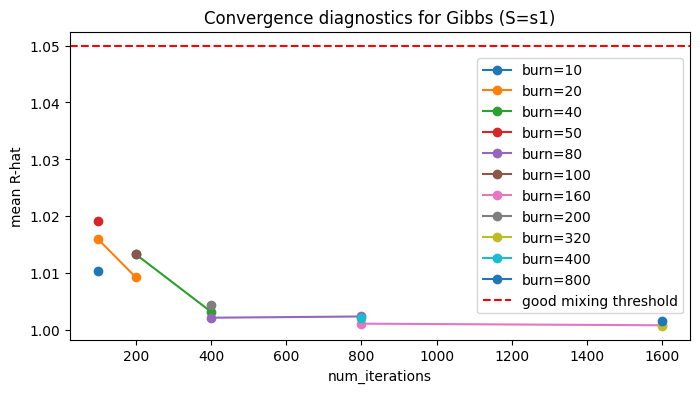

In [71]:
plt.figure(figsize=(8,4))
for burn_frac, group in rhat_df.groupby("burn_in"):
    plt.plot(group["iterations"], group["mean_rhat"], marker="o", label=f"burn={burn_frac}")

plt.axhline(1.05, color="red", linestyle="--", label="good mixing threshold")
plt.xlabel("num_iterations")
plt.ylabel("mean R-hat")
plt.legend()
plt.title("Convergence diagnostics for Gibbs (S=s1)")
plt.show()

## Expectations

Often, we are not interested in the underlying distribution or the samples themselves, but in quantitative metrics that depend on them.

In a medical setting, for example, we might want to estimate a patient’s suffering (e.g., the expected number of symptoms), expected treatment costs, or expected duration of treatment. These quantities are functions of assignments of the model.

Formally, if a model $P_\Phi$ assigns a probability to each possible outcome $x \in \text{Val}(X)$ of an rv $X$, and a function \($f(x)$\) maps that outcome to the value we care about, then the expectation is

$$
\mathbb{E}[f(X)]
=
\sum_{x \in \text{Val}(X)} f(x)\, P_\Phi(x)
$$

This is the **exact** expectation: a weighted sum over *all* assignments.  
However, for most realistic models this summation is intractable because the number of assignments grows exponentially in the number of variables.

To avoid this, we approximate the expectation using sampling. If we could draw $M$ independent samples $x_i \sim P_\Phi(X)$, we could estimate the expectation as  

$$
\mathbb{E}_{}[f(X)]
\;\approx\;
\hat{\mathbb{E}}[f(X)]
=
\frac{1}{M} \sum_{i=1}^M f(x[i]).
$$

In practice, exact independent samples are usually unavailable. Instead, we generate samples using **Gibbs sampling**, which produces a *Markov chain* whose stationary distribution is $P_\Phi(X)$. The samples in this chain are correlated and not independent, but the same estimator above is still **consistent**: as the chain gets long enough (after burn-in and with sufficient thinning if desired), the average converges to the true expected value.

This makes sampling a practical and scalable alternative when exact computation is impossible.

**EXERCISE – Computing Expectations**

Complete the functions below to compute expectations from Gibbs samples. The function takes the generated chain of samples, applies a function to them (e.g. counting symptoms, evaluating costs, computing treatment time), and returns the average value.  

Then, for the medical BN, report
* Expected number of symptoms
* Expected treatment cost
* Expected recovery time
1) sampling _without_ evidence, and 2) sampling _given_ $S=s^1$.

For this experiment you can use `num_iterations=5000` and `burn_in=100`. You may perform this experiment using a single chain. 


In [72]:
def expected_n_symptoms(samples: list):
    """
    Compute the expected number of symptoms from Gibbs samples.
    
    Symptoms are: ST (Sore Throat), F (Fever), C (Cough), W (Wheezing)
    
    Parameters:
    -----------
    samples : list of dict
        List of sample dictionaries from Gibbs sampling
    
    Returns:
    --------
    expected : float
        Expected number of symptoms (0-4)
    """
    symptom_vars = ['ST', 'F', 'C', 'W']
    
    totals = []
    for s in samples:
        count = sum(1 for v in symptom_vars if s[v].endswith('1'))
        totals.append(count)
        
    return np.mean(totals)

def expected_treatment_cost(samples: list):
    """
    Compute the expected treatment cost from Gibbs samples.
    
    Cost structure:
    - Influenza (I): €50
    - Sore Throat (ST): €20
    - Fever (F): €30
    - Bronchitis (B): €100
    - Cough (C): €25
    - Wheezing (W): €40
    
    Parameters:
    -----------
    samples : list of dict
        List of sample dictionaries from Gibbs sampling
    
    Returns:
    --------
    expected_cost : float
        Expected treatment cost in euros
    """
    costs = {
        'I': 50,
        'ST': 20,
        'F': 30,
        'B': 100,
        'C': 25,
        'W': 40,
    }
    
    totals = []
    for s in samples:
        total = sum(costs[v] for v in costs if s[v].endswith('1'))
        totals.append(total)
        
    return np.mean(totals)


def expected_recovery_time(samples: list):
    """
    Compute the expected recovery time (in days) from Gibbs samples.
    
    Recovery time structure:
    - Influenza (I): 7 days
    - Sore Throat (ST): 3 days
    - Fever (F): 2 days
    - Bronchitis (B): 10 days
    - Cough (C): 5 days
    - Wheezing (W): 4 days
    
    Note: Recovery time is the maximum of all present conditions (conditions overlap).
    
    Parameters:
    -----------
    samples : list of dict
        List of sample dictionaries from Gibbs sampling
    
    Returns:
    --------
    expected_time : float
        Expected recovery time in days
    """
    days = {
        'I': 7,
        'ST': 3,
        'F': 2,
        'B': 10,
        'C': 5,
        'W': 4,
    }
    
    totals = []
    for s in samples:
        active = [days[v] for v in days if s[v].endswith('1')]
        if len(active) == 0:
            totals.append(0)
        else:
            totals.append(max(active))
            
    return np.mean(totals)


This is to help you test the expectations _without evidence_.

In [73]:
samples = gibbs_sampler(
    medical_bn,
    draw_initial_assignment(medical_bn),
    num_iterations=5000,
    burn_in=100,
)
assert np.isclose(expected_n_symptoms(samples), 0.6, rtol=0.3)
assert np.isclose(expected_treatment_cost(samples), 50.0, rtol=0.3)
assert np.isclose(expected_recovery_time(samples), 3.0, rtol=0.3)


# Use of AI Tools

By submitting this notebook for grading you testify that:

* AI did not draft an earlier version of your work.
* You did not use AI-powered code completion.
* You did not implement algorithms suggested by an AI tool.
* AI did not revise a version of your work.
* You did not implement suggestions made by an AI tool.


_You_ in the sentences above refers to you and all your team members.
_AI_ refers to LM-based tools and assistants (e.g., ChatGPT, Gemini, UvA AI chat, etc.).

If you did make use of an AI tool, you should describe the uses you made of it below. Or indicate that no such tool was used. 

**TYPE YOUR STATEMENT HERE**

In [74]:
# No use of AI other then testing and looking things up about PGM